# Baixar imagens do Sentinel-2 do Planetary Computer (Microsoft)

Creation: 26/06/2024 <br>
Modified: 26/07/2024 <br>
Dificuldade: Média<br>
Criação: Sabrina P. L. P. Correa (paeslemesa@gmail.com)

Descrição: A partir de uma área de interesse (AOI) baixa cenas inteiras que a envolvem. Este código vai baixar todas as cenas inteiras no intervalo de tempo selecionado considerando a percentagem máxima de nuvens.


References:
* https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
* https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a

## Importando bibliotecas

In [1]:
from pathlib import Path # para gerenciar caminhos de arquivos

import numpy as np # para manipulação de arrays

import rasterio.features # para extrair geometrias de rasters
import rasterio # para abrir rasters

import pystac_client # para acessar catálogos STAC
import planetary_computer # para autenticar com o Planetary Computer

import geopandas as gpd # para manipulação de dados geoespaciais

## Entrada de dados

In [2]:
diretorio = r"E:\Pesquisa\00_Scripts\DownloadPlanetaryComputer" # Diretório onde os arquivos serão salvos
shpAOI = Path(diretorio, "AOI_Paris.geojson") # Arquivo de entrada com a área de interesse no EPSG 4326

date_ini = "2023-07-20" # Data inicial no formato YYYY-MM-DD
date_end = "2023-08-31" # Data final no formato YYYY-MM-DD

cloud = 5 # Porcentagem de nuvens

bandas = ['B02', 'B03', 'B04', 'B08'] # Bandas a serem baixadas (B02: Azul, B03: Verde, B04: Vermelho, B08: Infravermelho próximo)

Primeiro vamos abrir nosso shapefile/geojson. Lembrando que pra selecionar a AOI, a gente tem que usar a AOI no crs EPSG: 4326.

Caso seu shapefile não esteja nesse sistema, tudo bem, nós vamos converter :D

In [3]:
gdf = gpd.read_file(shpAOI) # Lê o arquivo de entrada
gdf = gdf.to_crs("EPSG:4326") # Converte para o sistema de coordenadas EPSG:4326 (garantindo para o caso de o arquivo estar em outro sistema de coordenadas)
bbox = gdf.total_bounds # Obtém as coordenadas da área de interesse
bbox

array([ 2.30091888, 48.8451908 ,  2.3591802 , 48.87579381])

## 2. Acessando as imagens disponíveis no Planetary Computer

Aqui a gente seleciona como vamos baixar a imagem:
* Data de inicio
* Data de fim
* Qual coelção a ser usada (Sentinel-2, Landsat, MODIS...)
* Se tem alguma coisa a mais que queremos adicionar, como a percentagem máxima de núvens

In [4]:
# Definindo o site do filtro de busca

stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
# Realizando a busca no PyStac
search = stac.search(
    bbox=bbox, # Área de interesse
    datetime=f"{date_ini}/{date_end}", # Período de interesse
    collections=["sentinel-2-l2a"], # Coleção de interesse, no caso Sentinel-2 L2A. Outras coleções podem ser encontradas em https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a
    query={"eo:cloud_cover": {"lt": cloud}}, # Filtro de nuvens
)

In [6]:
# Obtendo os itens da busca
items = search.item_collection()
print("Cenas resultantes da busca: ",len(items))

Cenas resultantes da busca:  1


## 3. Baixando as imagens selecionadas

Aqui as imagens são baixadas por bandas. Primeiro a gente arquiva a imagem na memória do computador e depois a salva no computador no diretório selecionado.

In [7]:
for i in range(len(items)): # Loop para baixar as bandas de cada cena
    print(items[i].id) # Imprime o ID da cena
    
    for banda in bandas: # Loop para baixar cada banda
        print(f"\tBaixando banda {banda}...")
        with rasterio.open (items[i].assets[banda].href) as src:
            img_tmp = src.read(1) # Lê a banda
            profile = src.profile # Obtém o perfil da banda

        if banda == bandas[0]:
            img = img_tmp[np.newaxis, :, :]
        else:
            img = np.concatenate((img, img_tmp[np.newaxis,:,:]), axis=0) # Concatena a banda à imagem
        
    profile.update(count = img.shape[0]) # Atualiza o número de bandas no perfil
    NomeSaida = Path(diretorio, f"{items[i].id}.tif") # Define o nome do arquivo de saída, que sera o ID da imagem do Sentinel-2

    with rasterio.open(NomeSaida, 'w', **profile) as dst: # Salva a imagem NO COMPUTADOR
        dst.write(img)


S2B_MSIL2A_20230821T105629_R094_T31UDQ_20230823T203053
	Baixando banda B02...
	Baixando banda B03...
	Baixando banda B04...
	Baixando banda B08...


Pronto!
Podemos dar umas olhada na nossa imagem.

Aqui está um pedacinho dela em RGB, mostrando o Arco do Triunfo em Paris

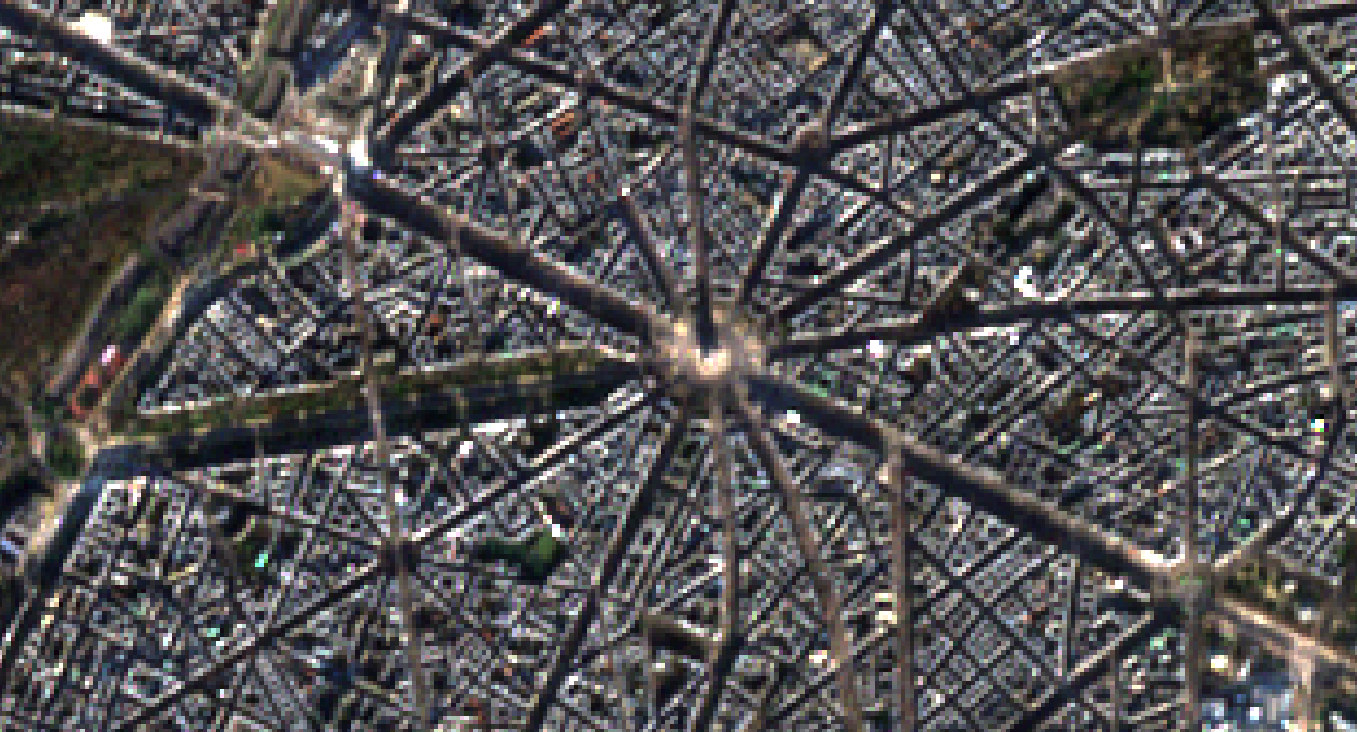